### 목적
- LangGraph 이해 및 기본 사용 예제

#### LangGraph
- 상태(state) 기반의 그래프 실행 엔진
    - LLM/툴 호출을 노드(Node)로, 사이 흐름을 엣지(Edge)로 정의하고 실행 중간 상태를 축적, 분기, 중단(인터럽트), 체크포인트 하며 안전하게 되감기/재개 할 수 있게 해준다.
- 최근 LangChain 에이전트 구현도 LangGraph 위에서 실행된다.

#### 단일 루프 vs LangGraph
- LangChain create_agent (단일 루프)
    - 장점: 빠른 시작, 기본 ReAct 루프/툴콜/미들웨어가 이미 준비 됨
    - 단점: 복잡한 분기, 병렬, 장기 워크플로우 관리 등에 한계

- LangGraph
    - 장점: 분기/조건 라우팅, 체크포인트/재개, 스트리밍 & 부분 업데이트
    - 단점: 설계가 필요

#### 설계 베스트 프랙티스
1. State 스키마 먼저 설계
2. 노드 책임을 작게
    - 의도분류, 검색, 답변초안, 승인대기, 전송 등 한 가지 일만
    - 노드 간 데이터 계약을 명확히 해야 한다.
3. 분기 조건은 상태 기반으로 명시
    - 예시) ```if intent == "email_send" and approval_required: go approve_node```
4. 체크포인트 전략
    - 사용자 입력 직후, 고비용 호출 전후, 외부부작용(이메일 전송) 직전에는 반드시 저장
    - 개발 초기엔 InMemorySaver -> 운영은 SQLite/PostgreSQL 같은 영속 저장소
5. 스트리밍 계획
    - UI 요구에 맞춰 messages 또는 updates를 선택
    - 토큰 흐름과 상태 갱신을 분리 출력하면 UX가 더 좋아짐
6. HITL(휴먼인더루프) 표준 패턴
    - 노드에서 ```interrupt("need_approval", payload=preview)```
    - 프론트는 preview를 보여주고, 사용자의 승인/수정/거부를 받아 ```Command(resume=...)```로 재개
7. 멀티에이전트 패턴 선택
    - Tool-Calling: 슈퍼바이저가 서브에이전트를 툴처럼 호출(단방향, 중앙집중)
    - Handoff: 주도권을 다른 에이전트로 넘김(분산, 대화 상대 변경)

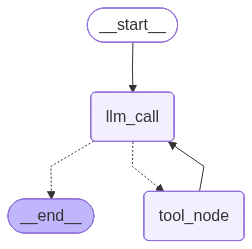

================================ Human Message =================================

3과 4를 더해줘
================================== Ai Message ==================================
Tool Calls:
  add (call_Cjidu9RH7ZGI1W81zC05cZ0p)
 Call ID: call_Cjidu9RH7ZGI1W81zC05cZ0p
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

3과 4를 더하면 7입니다.


: 

In [ ]:
import os
from dotenv import load_dotenv
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent

load_dotenv()

# 1. 툴, 모델 정의

model = ChatOpenAI(model='gpt-4o-mini', api_key=os.getenv('OPENAI_API_KEY'))

@tool
def multiply(a: int, b: int) -> int:
    """
    두 개의 수를 곱하세요.
    Args:
        a: First int
        b: Second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """
    두 개의 수를 더하세요.
    Args:
        a: First int
        b: Second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> int:
    """
    두 개의 수를 나누세요.
    Args:
        a: First int
        b: Second int
    """
    return a / b

tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

# 2. 상태(state) 정의
from langchain.messages import AnyMessage
# AnyMessage: LangChain의 모든 메시지 타입을 포괄하는 유니언 타입 별칭 (HumanMessage, AIMessage 등)
## LangGraph에서 list[AnyMessage]를 state 스키마에 넣고 관리
from typing_extensions import TypedDict, Annotated
# Annotated: 기본 타입에 메타데이터(주석)을 붙일 수 있는 타입 힌트
## 예시) Annotated[T, meta1, meta2]
## 해당 필드를 누적해서 합칠 때 사용(reducer)
import operator
# operator: 파이썬의 연산자(+, * 등)을 함수 형태로 제공하는 유틸 모듈
## 연산자 자체를 콜백/함수로 넘겨야 할 때 사용
## operator.add(a, b)는 a+b와 동일
## Annotated와 같이 누적해서 합칠 때 사용
## 예시) Annotated[List[AnyMessage], operator.add]

class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

# 3. 모델 노드 정의
from langchain.messages import SystemMessage

def llm_call(state: dict):
    """LLM은 도구를 호출할지 여부를 결정합니다."""
    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="당신은 일련의 입력에 대한 산술 연산을 수행하는 유용한 조수입니다."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

# 4. 툴 노드 정의
from langchain.messages import ToolMessage

def tool_node(state: dict):
    """도구 호출을 수행합니다."""
    result = []
    for tool_call in state["messages"][-1].tool_calls: # 직전 LLM이 사용하라고 지시한 툴 목록을 순회
        tool = tools_by_name[tool_call["name"]] # 툴 객체를 이름으로 조회
        observation = tool.invoke(tool_call["args"]) 
        # LangChain이 툴 정의를 LLM에게 보내고, 
        # LLM이 사용자 입력과 대화문맥을 보고인자(args)를 생성한다.
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

# 5. 로직 정의
from langgraph.graph import StateGraph, START, END
# StateGraph: LangGraph의 상태 기반 그래프 빌더
## 노드 연결, State 스키마에 맞춰 실행 흐름 관리 -> 상태 머신처럼 설계
## 생성 시 State 스키마를 넣는다. (보통 TypedDict + Annotated 로 병합 규칙)
## add_node(), add_edge()로 노드와 간선을 반든다.
## complie() 후 graph.invoke(state)로 실행

def should_continue(state: MessageState):
    """LLM이 도구 호출을 했는지 여부에 따라 루프를 계속할지 중지할지 결정합니다."""
    messages = state["messages"]
    last_message = messages[-1]

    # LLM이 툴 호출을 했다면 툴 노드 실행
    if last_message.tool_calls:
        return "tool_node"

    return END

# 6. 에이전트 빌드, 컴파일
agent_builder = StateGraph(MessageState)

# 노드 추가
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# 엣지 추가 및 노드 연결
agent_builder.add_edge(START, "llm_call") # 시작점을 llm_call 노드로
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# 에이전트 컴파일
agent = agent_builder.compile()

# 에이전트 보기
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# 실행
from langchain.messages import HumanMessage
messages = [HumanMessage(content="3과 4를 더해줘")]
messages = agent.invoke({'messages': messages})
for m in messages["messages"]:
    m.pretty_print()


#### Graph 빌드와 컴파일
- build: 설계도를 만들기 위한 구조체
- complie: 만들어진 설계도를 실제 실행 가능한 Graph 객체로 변환해줌

#### 왜 빌드와 컴파일을 나누었나?
- 실행 엔진 재사용성 때문이다. -> LangGraph는 그래프를 한 번 설계한 뒤, 여러 번 실행할 수 있도록 설계되어 있음
- build()는 설계 정의 -> 동작 불가능한 선언적 구조
- 즉, 설계도가 논리적으로 말이 되는지 검증하는 단계가 compile()이다.
    - build() 단계에서는 논리 검증을 하지 않아서 에러가 발생하지 않는다.

| 단계          | 수행 시점          | 주 역할         | 실행 가능 여부       |
| ----------- | -------------- | ------------ | -------------- |
| `build()`   | 개발자가 그래프 설계할 때 | 노드/엣지/흐름 정의  | ❌ 불가능          |
| `compile()` | 설계가 완료된 뒤 한 번만 | 실행 가능한 객체 생성 | ✅ 가능           |
| `invoke()`  | 실제 요청마다        | 상태 넣고 실행     | ✅ 가능 (여러 번 가능) |

#### complie을 다시 하지 않는 게 좋은가?
- LangGraph 내부에서 그래프 구조를 새로 검증하고 최적화하기 때문에 불필요한 오버헤드 발생
- checkpoint와 state의 연속성도 끊어질 수 있음


In [ ]:
# build 단계와 compile 단계에서의 에러 검증 예시 코드

from langgraph.graph import StateGraph, END

class State():
    greet: str

graph = StateGraph(State)

def start(state):
    return {"msg": "hello"}

graph.add_node("start", start)
graph.add_edge("start", "next") # next라는 노드가 없어도 에러가 발생하지 않음

app = graph.compile() # compile 시점에서 에러 발생

ValueError: Graph must have an entrypoint: add at least one edge from START to another node